In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


Dataset Description
In this competition your task is to predict whether a passenger was transported to an alternate dimension during the Spaceship Titanic's collision with the spacetime anomaly. To help you make these predictions, you're given a set of personal records recovered from the ship's damaged computer system.


File and Data Field Descriptions

train.csv - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.

PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.

HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.

CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.

Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.

Destination - The planet the passenger will be debarking to.

Age - The age of the passenger.

VIP - Whether the passenger has paid for special VIP service during the voyage.

RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.

Name - The first and last names of the passenger.

Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

test.csv - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data. Your task is to predict the value of Transported for the passengers in this set.

sample_submission.csv - A submission file in the correct format.

PassengerId - Id for each passenger in the test set.

Transported - The target. For each passenger, predict either True or False.

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

**Reading the Data**

In [3]:
train = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
test = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')

In [4]:
train.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [5]:
test.isna().sum()

PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64

**Data Imputation**

In [6]:
train['Group'] = train['PassengerId'].str.split('_').str[0]

train['TotalExpenditure'] = train[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']].sum(axis=1)

train[['Deck','Num','Side']] = train['Cabin'].str.split('/',expand=True)

train['Num'] = pd.to_numeric(train['Num'])

In [7]:
test['Group'] = test['PassengerId'].str.split('_').str[0]

test['TotalExpenditure'] = test[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']].sum(axis=1)

test[['Deck','Num','Side']] = test['Cabin'].str.split('/',expand=True)

test['Num'] = pd.to_numeric(test['Num'])

**Replacing HomePlanet with HomePlanet of people in the same group**

In [8]:
for group in train['Group'].unique():
    homeplanet_mode = train.loc[train['Group'] == group,'HomePlanet'].mode()
    
    if not homeplanet_mode.empty:
        train.loc[(train['Group'] == group) & (train['HomePlanet'].isnull()),'HomePlanet'] = homeplanet_mode[0]


for group in test['Group'].unique():
    homeplanet_mode = test.loc[test['Group'] == group,'HomePlanet'].mode()
    
    if not homeplanet_mode.empty:
        test.loc[(test['Group'] == group) & (test['HomePlanet'].isnull()),'HomePlanet'] = homeplanet_mode[0]

In [9]:
train['HomePlanet'].isna().sum()

111

In [10]:
train['HomePlanet'].value_counts()

HomePlanet
Earth     4634
Europa    2161
Mars      1787
Name: count, dtype: int64

In [11]:
train['HomePlanet'] = train['HomePlanet'].fillna('Mars')

In [12]:
test['HomePlanet'].value_counts()

HomePlanet
Earth     2280
Europa    1014
Mars       937
Name: count, dtype: int64

In [13]:
test['HomePlane'] = test['HomePlanet'].fillna('Mars')

In [14]:
train['HomePlanet'].isna().sum()

0

In [15]:
test['HomePlane'] = test['HomePlanet'].fillna('Mars')

In [16]:
print(test.loc[276])

PassengerId                 0616_01
HomePlanet                      NaN
CryoSleep                     False
Cabin                        E/40/S
Destination             TRAPPIST-1e
Age                            31.0
VIP                           False
RoomService                     0.0
FoodCourt                     428.0
ShoppingMall                    NaN
Spa                          1154.0
VRDeck                       1025.0
Name                Arkaban Spriney
Group                          0616
TotalExpenditure             2607.0
Deck                              E
Num                            40.0
Side                              S
HomePlane                      Mars
Name: 276, dtype: object


In [17]:
print((test['HomePlanet'] == '').sum())  

0


In [18]:
print(test['HomePlanet'].unique()) 

['Earth' 'Europa' 'Mars' nan]


In [19]:
test.loc[test['HomePlanet'].isna(), 'HomePlanet'] = 'Mars'

In [20]:
test['HomePlanet'].isna().sum()

0

**Replcing missing expenditures with 0 assuming they have spent nothing**

In [21]:

train['RoomService'] = train['RoomService'].fillna(0)
train['FoodCourt'] = train['FoodCourt'].fillna(0)
train['ShoppingMall'] = train['ShoppingMall'].fillna(0)
train['Spa'] = train['Spa'].fillna(0)
train['VRDeck'] = train['VRDeck'].fillna(0)


test['RoomService'] = test['RoomService'].fillna(0)
test['FoodCourt'] = test['FoodCourt'].fillna(0)
test['ShoppingMall'] = test['ShoppingMall'].fillna(0)
test['Spa'] = test['Spa'].fillna(0)
test['VRDeck'] = test['VRDeck'].fillna(0)

**If Passengers has spent nothing that might imply that they have been put to CryoSleep**

In [22]:
train.loc[train['CryoSleep'].isnull(), 'CryoSleep'] = train['TotalExpenditure'] == 0
test.loc[train['CryoSleep'].isnull(), 'CryoSleep'] = test['TotalExpenditure'] == 0

In [23]:
train['CryoSleep'].isna().sum()

0

In [24]:
test['CryoSleep'].isna().sum()

93

In [25]:
test.loc[test['CryoSleep'].isna(), 'CryoSleep'] = True

In [26]:
test['CryoSleep'].isna().sum()

0

In [27]:
test.loc[train['CryoSleep'].isnull(), 'CryoSleep'] = True

In [28]:
test.isna().sum()

PassengerId           0
HomePlanet            0
CryoSleep             0
Cabin               100
Destination          92
Age                  91
VIP                  93
RoomService           0
FoodCourt             0
ShoppingMall          0
Spa                   0
VRDeck                0
Name                 94
Group                 0
TotalExpenditure      0
Deck                100
Num                 100
Side                100
HomePlane             0
dtype: int64

**Replacing missing Destination with Destination of each group**

In [29]:
for group in train['Group'].unique():
    destination_mode = train.loc[train['Group'] == group, 'Destination'].mode()
    
    if not destination_mode.empty:
        train.loc[(train['Group'] == group) & (train['Destination'].isnull()),'Destination'] = destination_mode[0]
    
for group in test['Group'].unique():
    destination_mode = test.loc[test['Group'] == group, 'Destination'].mode()
    
    if not destination_mode.empty:
        test.loc[(test['Group'] == group) & (test['Destination'].isnull()),'Destination'] = destination_mode[0]
    
    

In [30]:
train['Destination'].value_counts()

Destination
TRAPPIST-1e      5969
55 Cancri e      1816
PSO J318.5-22     805
Name: count, dtype: int64

In [31]:
train['Destination'] = train['Destination'].fillna('PSO J318.5-22')

In [32]:
test['Destination'].value_counts()

Destination
TRAPPIST-1e      2985
55 Cancri e       850
PSO J318.5-22     391
Name: count, dtype: int64

In [33]:
test['Destination'] = test['Destination'].fillna('PSO J318.5-22')

**Repalcing Age with mean Age of each group**

In [34]:
for group in train['Group'].unique():
    age_mean = train.loc[train['Group'] == group, 'Age'].mean()
    
    train.loc[(train['Group'] == group) & (train['Age'].isna()),'Age'] = age_mean

for group in test['Group'].unique():
    age_mean = test.loc[test['Group'] == group, 'Age'].mean()
    
    test.loc[(test['Group'] == group) & (test['Age'].isna()),'Age'] = age_mean

In [35]:
train['Age'].isna().sum()
test['Age'].isna().sum()

47

In [36]:
train['Age'] = train['Age'].fillna(train['Age'].mean())
test['Age'] = test['Age'].fillna(test['Age'].mean())

**Replacing Side, Deck with Side, Deck of people in the same group assuming people from same group would sit together**

In [37]:
for group in train['Group'].unique():
    deck_mode = train.loc[train['Group'] == group, 'Deck'].mode()
    
    if not deck_mode.empty:
        train.loc[(train['Group'] == group) & (train['Deck'].isna()), 'Deck'] = deck_mode[0]

for group in test['Group'].unique():
    deck_mode = test.loc[test['Group'] == group, 'Deck'].mode()
    
    if not deck_mode.empty:
        test.loc[(test['Group'] == group) & (test['Deck'].isna()), 'Deck'] = deck_mode[0]

In [38]:

for group in train['Group'].unique():
    deck_mode = train.loc[train['Group'] == group, 'Side'].mode()
    
    if not deck_mode.empty:
        train.loc[(train['Group'] == group) & (train['Side'].isna()), 'Side'] = deck_mode[0]

for group in test['Group'].unique():
    deck_mode = test.loc[test['Group'] == group, 'Side'].mode()
    
    if not deck_mode.empty:
        test.loc[(test['Group'] == group) & (test['Side'].isna()), 'Side'] = deck_mode[0]

In [39]:
train.isna().sum()

PassengerId           0
HomePlanet            0
CryoSleep             0
Cabin               199
Destination           0
Age                   0
VIP                 203
RoomService           0
FoodCourt             0
ShoppingMall          0
Spa                   0
VRDeck                0
Name                200
Transported           0
Group                 0
TotalExpenditure      0
Deck                 99
Num                 199
Side                 99
dtype: int64

In [40]:
test.isna().sum()

PassengerId           0
HomePlanet            0
CryoSleep             0
Cabin               100
Destination           0
Age                   0
VIP                  93
RoomService           0
FoodCourt             0
ShoppingMall          0
Spa                   0
VRDeck                0
Name                 94
Group                 0
TotalExpenditure      0
Deck                 63
Num                 100
Side                 63
HomePlane             0
dtype: int64

In [41]:
for group in train['Group'].unique():
    destination_mode = train.loc[train['Group'] == group, 'Destination'].mode()
    
    if not destination_mode.empty:
        train.loc[(train['Group'] == group) & (train['Destination'].isnull()),'Destination'] = destination_mode[0]
    

for group in test['Group'].unique():
    destination_mode = test.loc[test['Group'] == group, 'Destination'].mode()
    
    if not destination_mode.empty:
        test.loc[(test['Group'] == group) & (test['Destination'].isnull()),'Destination'] = destination_mode[0]
    
    

In [42]:
test['Destination'].isna().sum()

0

In [43]:
train['Deck'].isna().sum()

99

In [44]:
train['Deck'] = train['Deck'].fillna('T')


In [45]:
test['Deck'] = test['Deck'].fillna('T')

**Replacing VIP with same  group status VIP True/False**

In [46]:
for group in train['Group'].unique():
    vip_mode = train.loc[train['Group'] == group, 'VIP'].mode()
    
    if not vip_mode.empty:
        train.loc[(train['Group'] == group) & (train['VIP'].isna()), 'VIP'] = vip_mode[0]
        

for group in test['Group'].unique():
    vip_mode = test.loc[test['Group'] == group, 'VIP'].mode()
    
    if not vip_mode.empty:
        test.loc[(test['Group'] == group) & (test['VIP'].isna()), 'VIP'] = vip_mode[0]
        
    

In [47]:
vip_mode[0]

False

In [48]:
train['VIP'] = train['VIP'].fillna(False)
test['VIP'] = test['VIP'].fillna(False)

/tmp/ipykernel_17/2557423949.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train['VIP'] = train['VIP'].fillna(False)
/tmp/ipykernel_17/2557423949.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test['VIP'] = test['VIP'].fillna(False)


In [49]:
train['VIP'].unique()

array([False,  True])

In [50]:
for group in train['Group'].unique():
    Num_mean = train.loc[train['Group'] == group, 'Num'].mean()
    
    train.loc[(train['Group'] == group) & (train['Num'].isna()),'Num'] = Num_mean

In [51]:
for group in test['Group'].unique():
    Num_mean = test.loc[train['Group'] == group, 'Num'].mean()
    
    test.loc[(test['Group'] == group) & (test['Num'].isna()),'Num'] = Num_mean

In [52]:
train['Num'] = train['Num'].fillna(train['Num'].mode())

In [53]:
test['Num'] = test['Num'].fillna(test['Num'].mode())

In [54]:
train['Side'].value_counts()

Side
S    4343
P    4251
Name: count, dtype: int64

In [55]:
train['Side'] = train['Side'].fillna('P')

In [56]:
test['Side'] = test['Side'].fillna('P')

In [57]:
train['Cabin'] = train['Cabin'].fillna(train['Deck'] +'/'+train['Num'].astype(str)+'/'+train['Side'])

In [58]:
test['Cabin'] = test['Cabin'].fillna(train['Deck'] +'/'+test['Num'].astype(str)+'/'+test['Side'])

In [59]:
train.isna().sum()

PassengerId           0
HomePlanet            0
CryoSleep             0
Cabin                 0
Destination           0
Age                   0
VIP                   0
RoomService           0
FoodCourt             0
ShoppingMall          0
Spa                   0
VRDeck                0
Name                200
Transported           0
Group                 0
TotalExpenditure      0
Deck                  0
Num                  99
Side                  0
dtype: int64

In [60]:
test.isna().sum()

PassengerId           0
HomePlanet            0
CryoSleep             0
Cabin                 0
Destination           0
Age                   0
VIP                   0
RoomService           0
FoodCourt             0
ShoppingMall          0
Spa                   0
VRDeck                0
Name                 94
Group                 0
TotalExpenditure      0
Deck                  0
Num                 100
Side                  0
HomePlane             0
dtype: int64

**EDA**

In [61]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Group,TotalExpenditure,Deck,Num,Side
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0001,0.0,B,0.0,P
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,0002,736.0,F,0.0,S
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,0003,10383.0,A,0.0,S
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,0003,5176.0,A,0.0,S
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,0004,1091.0,F,1.0,S


In [62]:
def age_group(x):
    if 10 < x and x < 20:
        return '10-20'
    elif 21 <= x and x <= 30:
        return '21-30'
    elif 31 <= x and x <= 40:
        return '31-40'
    elif 41 <= x and x <= 50:
        return '41-50'
    elif 51 <= x and x <= 60:
        return '51-60'
    elif 61 <= x and x <= 70:
        return '61-70'
    elif 71 <= x and x <= 80:
        return '71-80'
    else:
        return '>80'

In [63]:
train['AgeGroup'] = train['Age'].apply(age_group)

<Axes: xlabel='AgeGroup', ylabel='count'>

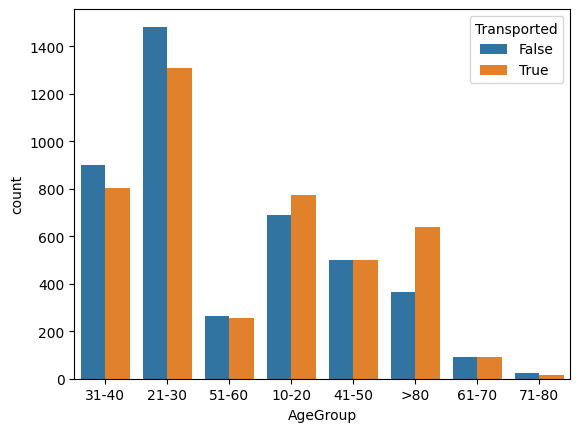

In [64]:
sns.countplot(x='AgeGroup',data=train,hue='Transported')

In [65]:
train_data = train[(train['Age'] <= 50)]

<Axes: xlabel='HomePlanet', ylabel='count'>

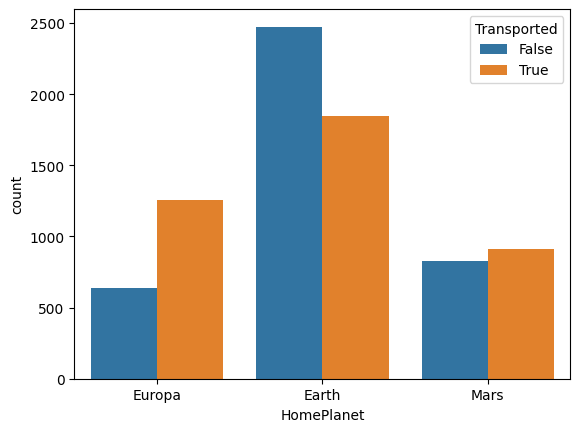

In [66]:
sns.countplot(x='HomePlanet',data=train_data,hue='Transported')

Observation: From Earth there are more people who travelled
    
Feature to consider: HomePlanet

<Axes: xlabel='Destination', ylabel='count'>

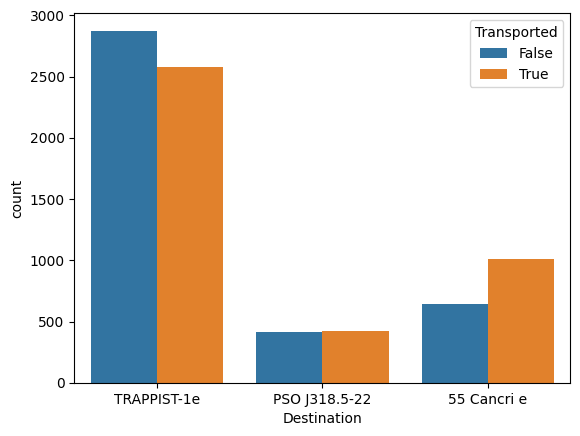

In [67]:
sns.countplot(x='Destination',data=train_data,hue='Transported')

Observation: Most of the people transported to TRAPPIST-1e destination
    
feature to consider: Destination

<Axes: xlabel='VIP', ylabel='count'>

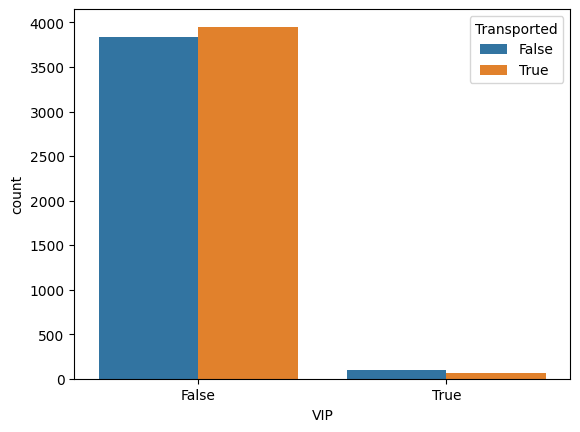

In [68]:
sns.countplot(x='VIP',data=train_data,hue='Transported')

Observation: Most of the Voyegers were not VIP
    
feature to consider: Voyegers

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: xlabel='TotalExpenditure', ylabel='Age'>

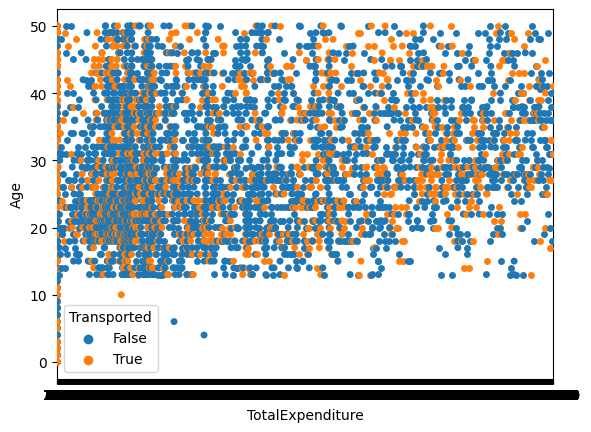

In [69]:
sns.stripplot(x='TotalExpenditure',y='Age',data=train_data,hue='Transported')

<Axes: xlabel='VIP', ylabel='count'>

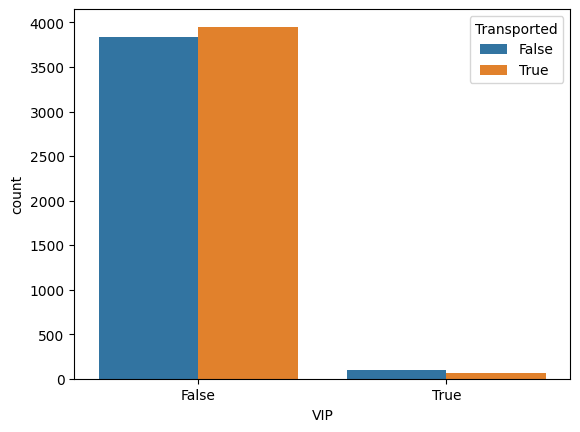

In [70]:
sns.countplot(x='VIP',data=train_data,hue='Transported')

Observation: Most of the Voyegers were not VIP
    
feature to consider: Voyegers

**Model Training**

In [71]:
X = train_data[['Age','HomePlanet','Destination','TotalExpenditure','CryoSleep','VIP']]
y = train_data['Transported']

In [72]:
X

,Age,HomePlanet,Destination,TotalExpenditure,CryoSleep,VIP
0,39.0,Europa,TRAPPIST-1e,0.0,False,False
1,24.0,Earth,TRAPPIST-1e,736.0,False,False
3,33.0,Europa,TRAPPIST-1e,5176.0,False,False
4,16.0,Earth,TRAPPIST-1e,1091.0,False,False
5,44.0,Earth,PSO J318.5-22,774.0,False,False
...,...,...,...,...,...,...
8688,41.0,Europa,55 Cancri e,8536.0,False,True
8689,18.0,Earth,PSO J318.5-22,0.0,True,False
8690,26.0,Earth,TRAPPIST-1e,1873.0,False,False
8691,32.0,Europa,55 Cancri e,4637.0,False,False


In [73]:
X.dtypes

Age                 float64
HomePlanet           object
Destination          object
TotalExpenditure    float64
CryoSleep            object
VIP                    bool
dtype: object

In [74]:
X['HomePlanet'] = X['HomePlanet'].astype(str)  # Ensure column is string type
X['Destination'] = X['Destination'].astype(str)  # Ensure column is string type
X['CryoSleep'] = X['CryoSleep'].astype(str)  # Ensure column is string type
X['VIP'] = X['VIP'].astype(str)  # Ensure column is string type


/tmp/ipykernel_17/3638390401.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['HomePlanet'] = X['HomePlanet'].astype(str)  # Ensure column is string type
/tmp/ipykernel_17/3638390401.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Destination'] = X['Destination'].astype(str)  # Ensure column is string type
/tmp/ipykernel_17/3638390401.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

In [75]:
X.dtypes

Age                 float64
HomePlanet           object
Destination          object
TotalExpenditure    float64
CryoSleep            object
VIP                  object
dtype: object

In [76]:
encoding = LabelEncoder()

cat_features = ['HomePlanet','Destination','CryoSleep','VIP']

for f in cat_features:
    X[f] = encoding.fit_transform(X[f])

/tmp/ipykernel_17/361920014.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f] = encoding.fit_transform(X[f])
/tmp/ipykernel_17/361920014.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f] = encoding.fit_transform(X[f])
/tmp/ipykernel_17/361920014.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

In [77]:
X

,Age,HomePlanet,Destination,TotalExpenditure,CryoSleep,VIP
0,39.0,1,2,0.0,0,0
1,24.0,0,2,736.0,0,0
3,33.0,1,2,5176.0,0,0
4,16.0,0,2,1091.0,0,0
5,44.0,0,1,774.0,0,0
...,...,...,...,...,...,...
8688,41.0,1,0,8536.0,0,1
8689,18.0,0,1,0.0,1,0
8690,26.0,0,2,1873.0,0,0
8691,32.0,1,0,4637.0,0,0


In [78]:
for f in cat_features:
    print(X[f].unique())

[1 0 2]
[2 1 0]
[0 1]
[0 1]


In [79]:
for f in cat_features:
    print(X[f].unique())

[1 0 2]
[2 1 0]
[0 1]
[0 1]


In [80]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=10,test_size=0.25)

In [81]:
model = DecisionTreeClassifier(criterion='entropy')

In [82]:
model.fit(X_train,y_train)
model.score(X_test,y_test)

0.6641528406234288

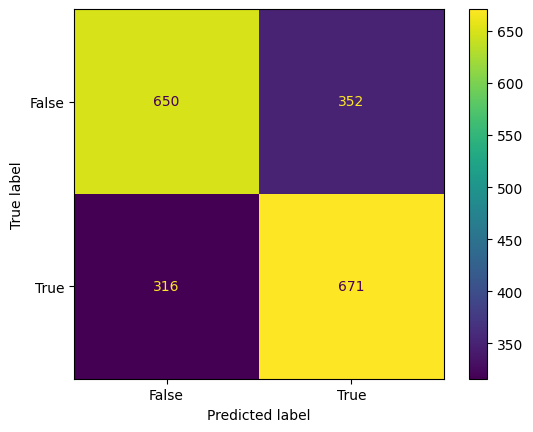

In [83]:
ConfusionMatrixDisplay.from_estimator(model,X_test,y_test)

356 people are not transported but model says they are transported. Which is fatal because no measure will be taken to identify the people who are not transported.
315 people are transported but model says they are not transported which is fine anyhow they are transported no harm.
Our main is to reduce this reduce 356.

In [84]:
accuracy1 = []
for k in range(2,15,2):
    model = DecisionTreeClassifier(criterion='entropy',max_depth=k,max_leaf_nodes=30)
    model.fit(X_train,y_train)
    accuracy1.append(model.score(X_test,y_test))

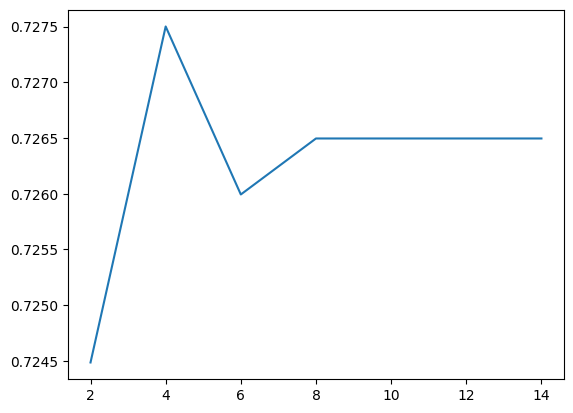

In [85]:
plt.plot(range(2,15,2), accuracy1, label = 'Test Accuracy')

best accuracy is at max_depth 4

In [86]:
model = DecisionTreeClassifier(criterion='entropy',max_depth=4,max_leaf_nodes=30)

In [87]:
model.fit(X_train,y_train)
model.score(X_test,y_test)

0.7275012569130216

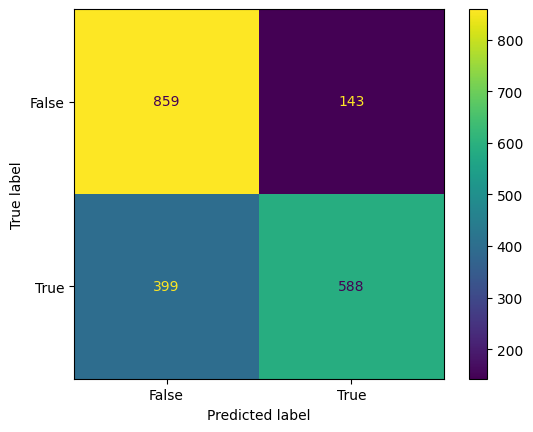

In [88]:
ConfusionMatrixDisplay.from_estimator(model,X_test,y_test)

356 came down to 143 after pruning

**Checking Feature importances**

In [89]:
model.feature_importances_

array([0.05213369, 0.19496083, 0.0085877 , 0.70472847, 0.03958932,
       0.        ])

removing VIP and Destination as they have less contribution

In [90]:
X = X[['Age','HomePlanet','TotalExpenditure','CryoSleep']]

In [91]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=10,test_size=0.25)

In [92]:
model = DecisionTreeClassifier(criterion='entropy',max_depth=4,max_leaf_nodes=30)

In [93]:
model.fit(X_train,y_train)
model.score(X_test,y_test)

0.7280040221216691

**72.8 is the higest accuracy till not, therefore my best features are ['Age','HomePlanet','TotalExpenditure','CryoSleep']**

**Testing Data**

In [94]:
input_test_data = test[['Age','HomePlanet','TotalExpenditure','CryoSleep']]

In [95]:
cat_features = ['HomePlanet','CryoSleep']
for f in cat_features:
    print(input_test_data[f].unique())

['Earth' 'Europa' 'Mars']
[True False]


In [96]:
encoding = LabelEncoder()

cat_features = ['HomePlanet','CryoSleep']

for f in cat_features:
    input_test_data[f] = encoding.fit_transform(input_test_data[f])

/tmp/ipykernel_17/1276233702.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_test_data[f] = encoding.fit_transform(input_test_data[f])
/tmp/ipykernel_17/1276233702.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_test_data[f] = encoding.fit_transform(input_test_data[f])


In [97]:
input_test_data

,Age,HomePlanet,TotalExpenditure,CryoSleep
0,27.000000,0,0.0,1
1,19.000000,0,2832.0,0
2,31.000000,1,0.0,1
3,38.000000,1,7418.0,0
4,20.000000,0,645.0,0
...,...,...,...,...
4272,34.000000,0,0.0,1
4273,42.000000,0,1018.0,0
4274,28.621496,2,0.0,1
4275,28.621496,1,3203.0,0


In [98]:
test_data_predictions = model.predict(input_test_data)

In [99]:
result_df = pd.DataFrame({
    'PassengerId': test['PassengerId'],  # Extract IDs from the original DataFrame
    'Transported': test_data_predictions
})

# Save to Excel
result_df.to_csv('/kaggle/working/submission.csv', index=False)

In [100]:
sub = pd.read_csv("/kaggle/working/submission.csv")


In [101]:
sub.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,False
4,0023_01,False
